## Máster en Data Science - Series Temporales

# Theta Models
Autor: Ramón Morillo Barrera

## Dataset: Madrid.csv

Los modelos Theta son una técnica de pronóstico diseñada para mejorar la precisión de las predicciones de series temporales, combinando las ventajas de los modelos de suavizado exponencial con la descomposición aditiva de la serie. Esta metodología fue desarrollada por Assimakopoulos y Nikolopoulos en 2000 y se basa en una combinación de un modelo de suavizado exponencial simple y un ajuste mediante un parámetro que permite la captación de tendencias y estacionalidades de forma más efectiva. Su principal ventaja radica en su simplicidad y en su capacidad para manejar series temporales con patrones complejos, como tendencias y estacionalidades irregulares, sin la necesidad de realizar complejos ajustes previos en los datos.

En este contexto, se utilizarán los modelos Theta para realizar predicciones sobre las series temporales de autobús y metro de Madrid. La elección de este enfoque se debe a la capacidad del modelo para proporcionar pronósticos más precisos y confiables, especialmente en series con fluctuaciones estacionales y tendencias evidentes. Al aplicar este modelo a los datos de transporte de Madrid, buscamos obtener predicciones más exactas que nos permitan entender mejor los patrones de demanda y ofrecer pronósticos más robustos para la planificación y gestión de estos servicios públicos.

Veremos si superan a las predicciones de los modelos anteriormente probados ARIMA, SARIMA y ETS.

In [96]:
# librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.models import Theta, FourTheta, StatsForecastAutoTheta, AutoARIMA, StatsForecastAutoETS
from darts.metrics import mape, smape, mse, rmse
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts import concatenate
from darts.utils.statistics import plot_hist


import warnings
warnings.filterwarnings('ignore')

### Importación de datos


In [97]:
df_autobus_month = pd.read_csv('../data/processed/Madrid_autobus_month.csv', index_col='Periodo')
df_metro_month = pd.read_csv('../data/processed/Madrid_metro_month.csv', index_col='Periodo')
df_combined_month = pd.read_csv('../data/processed/Madrid_combined_month.csv', index_col='Periodo')

df_autobus_trim = pd.read_csv('../data/processed/Madrid_autobus_trim.csv', index_col='Periodo')
df_metro_trim = pd.read_csv('../data/processed/Madrid_metro_trim.csv', index_col='Periodo')
df_combined_trim = pd.read_csv('../data/processed/Madrid_combined_trim.csv', index_col='Periodo')

In [98]:
df_autobus_month = df_autobus_month[ 'Total']
df_autobus_trim = df_autobus_trim['Total']
df_combined_month = df_combined_month[ 'Total']
df_combined_trim = df_combined_trim['Total']
df_metro_month = df_metro_month['Total']
df_metro_trim = df_metro_trim['Total']

In [99]:
df_autobus_month.index = pd.to_datetime(df_autobus_month.index)
df_autobus_trim.index = pd.to_datetime(df_autobus_trim.index)
df_combined_month.index = pd.to_datetime(df_combined_month.index)
df_combined_trim.index = pd.to_datetime(df_combined_trim.index)
df_metro_month.index = pd.to_datetime(df_metro_month.index)
df_metro_trim.index = pd.to_datetime(df_metro_trim.index)

df_autobus_month = df_autobus_month.resample("M").last()
df_autobus_trim = df_autobus_trim.resample("QE").last()
df_combined_month = df_combined_month.resample("M").last()
df_combined_trim = df_combined_trim.resample("QE").last()
df_metro_month = df_metro_month.resample("M").last()
df_metro_trim = df_metro_trim.resample("QE").last()

***
## Modelos Theta

La implementación de modelos Theta se simplifica significativamente gracias a la librería Darts, una herramienta especializada para el modelado y pronóstico de series temporales en Python. Darts proporciona una interfaz intuitiva y flexible que permite configurar y entrenar modelos Theta de manera rápida, sin necesidad de realizar complejos preprocesamientos o ajustes manuales en los datos. Además, la biblioteca incluye funciones para evaluar y comparar modelos, facilitando la selección del más adecuado para cada caso. Esta facilidad de uso, combinada con la integración de herramientas para manejar tendencias y estacionalidades, hace que Darts sea una solución ideal para implementar modelos Theta.

En nuestro caso, vamos a convertir los datos a TimeSeries para generar un array con el que graficaremos la serie temporal.

In [100]:
df_autobus_month = TimeSeries.from_series(df_autobus_month)
df_autobus_trim = TimeSeries.from_series(df_autobus_trim)
df_combined_month = TimeSeries.from_series(df_combined_month)
df_combined_trim = TimeSeries.from_series(df_combined_trim)
df_metro_month = TimeSeries.from_series(df_metro_month)
df_metro_trim = TimeSeries.from_series(df_metro_trim)

In [101]:
df_autobus_month

<TimeSeries (DataArray) (Periodo: 153, component: 1, sample: 1)> Size: 1kB
array([[[36.564]],

       [[36.692]],

       [[38.554]],

       [[33.174]],

       [[37.975]],

       [[36.66 ]],

       [[29.267]],

       [[20.324]],

       [[31.025]],

       [[37.996]],

...

       [[37.694]],

       [[40.238]],

       [[41.474]],

       [[39.069]],

       [[44.205]],

       [[42.456]],

       [[40.315]],

       [[34.079]],

       [[25.805]],

       [[40.13 ]]])
Coordinates:
  * Periodo    (Periodo) datetime64[ns] 1kB 2012-01-31 2012-02-29 ... 2024-09-30
  * component  (component) object 8B 'Total'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Periodo'>

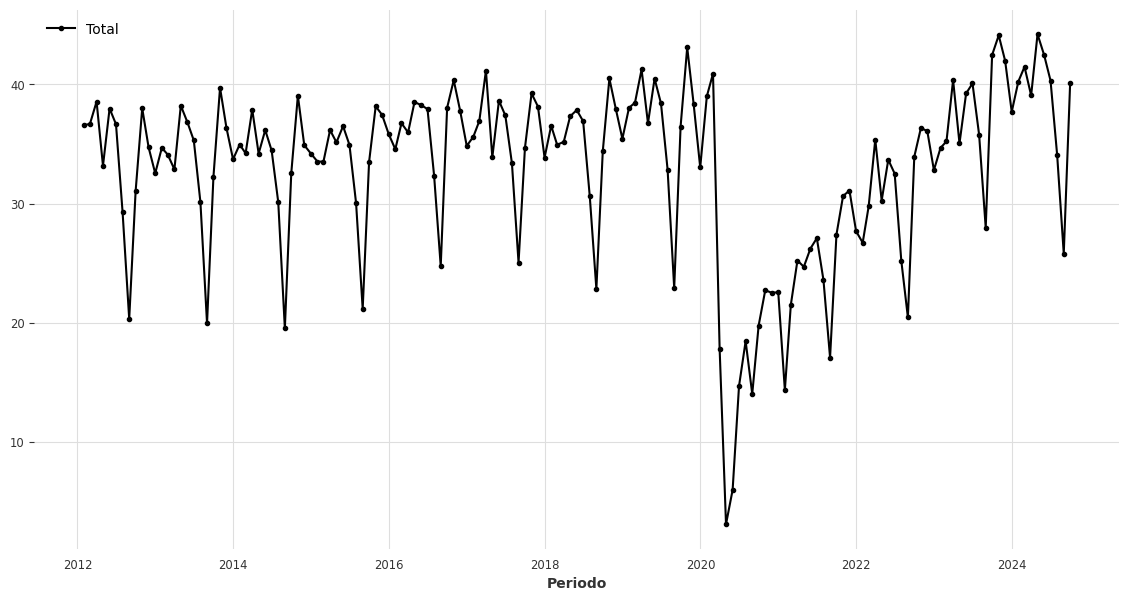

In [102]:
plt.figure(figsize=(14, 7))
df_autobus_month.plot(color='black', marker='o', markersize=3, linewidth=1.5)

### Generar predicciones con Theta

A continuación, voy a separar en entrenamiento y test. Generaré predicciones con un seasonality_period de 12 para las series de pasajeros mensuales y con un seasonality_period de 4 para las series temporales trimestrales.

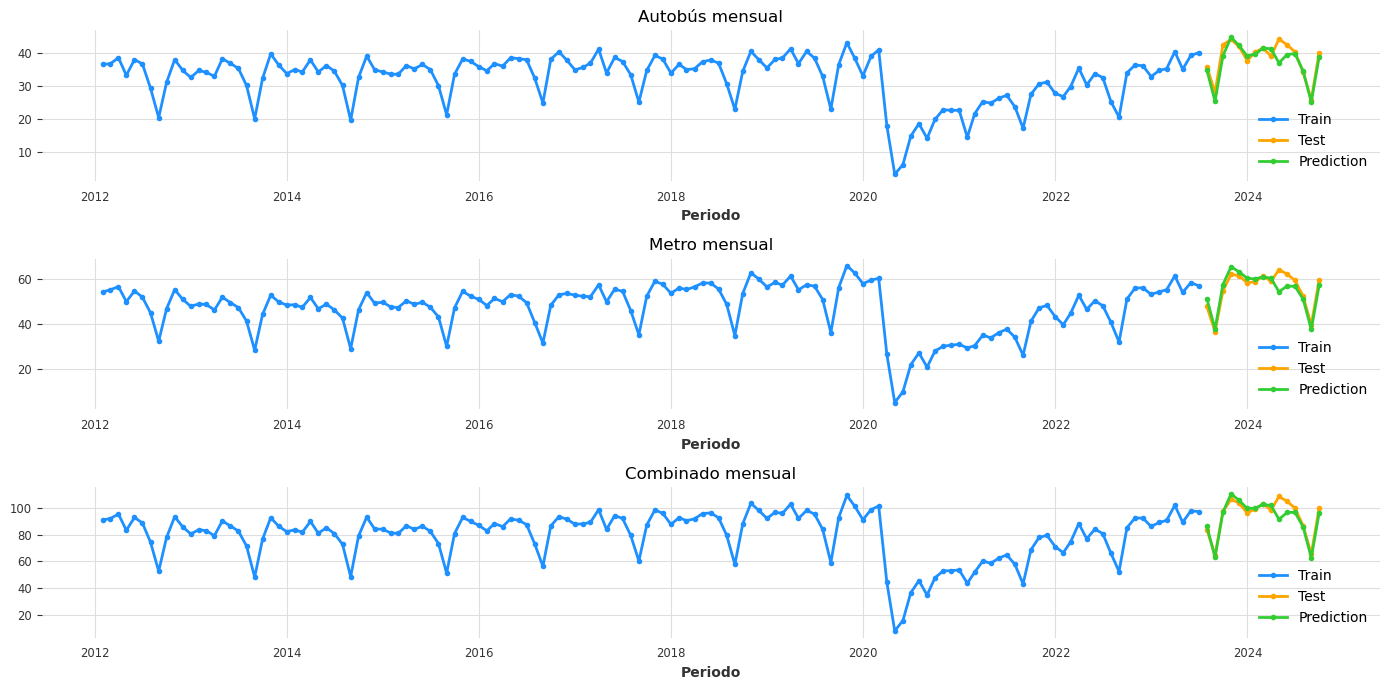

In [103]:
# Separar los datos en conjuntos de entrenamiento y prueba
train_autobus, test_autobus = df_autobus_month[:-15], df_autobus_month[-15:]
train_metro, test_metro = df_metro_month[:-15], df_metro_month[-15:]
train_combined, test_combined = df_combined_month[:-15], df_combined_month[-15:]

# Crear y entrenar el modelo Theta
theta_model = Theta(seasonality_period=12)

# Entrenar el modelo con los datos de autobús
theta_model.fit(train_autobus)
pred_autobus = theta_model.predict(len(test_autobus))

# Entrenar el modelo con los datos de metro
theta_model.fit(train_metro)
pred_metro = theta_model.predict(len(test_metro))

# Entrenar el modelo con los datos combinados
theta_model.fit(train_combined)
pred_combined = theta_model.predict(len(test_combined))

# Graficar los resultados
plt.figure(figsize=(14, 7))

# Graficar los datos de autobús
plt.subplot(3, 1, 1)
train_autobus.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
test_autobus.plot(label='Test', color='orange', marker='o', markersize=3)
pred_autobus.plot(label='Prediction', color='limegreen', marker='o', markersize=3)
plt.title('Autobús mensual')
plt.legend()

# Graficar los datos de metro
plt.subplot(3, 1, 2)
train_metro.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
test_metro.plot(label='Test', color='orange', marker='o', markersize=3)
pred_metro.plot(label='Prediction', color='limegreen', marker='o', markersize=3)
plt.title('Metro mensual')
plt.legend()

# Graficar los datos combinados
plt.subplot(3, 1, 3)
train_combined.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
test_combined.plot(label='Test', color='orange', marker='o', markersize=3)
pred_combined.plot(label='Prediction', color='limegreen', marker='o', markersize=3)
plt.title('Combinado mensual')
plt.legend()

plt.tight_layout()
plt.show()

A priori de manera visual, las predicciones para el periodo mensual son buenas, la predicción se ajusta bien a nuestros datos de test, tanto al principio como al final de la serie. Vemos un pico creciente que no consigue interpretar bien, salvo ese detalle la predicción parece bastante buena. Vamos a analizar las métricas de evaluación.

In [104]:
def calculate_metrics(test, pred):
    mse_value = mse(test, pred)
    rmse_value = rmse(test, pred)
    mape_value = mape(test, pred)
    return mse_value, rmse_value, mape_value

# Calcular métricas para las predicciones de autobús
mse_autobus, rmse_autobus, mape_autobus = calculate_metrics(test_autobus, pred_autobus)

# Calcular métricas para las predicciones de metro
mse_metro, rmse_metro, mape_metro = calculate_metrics(test_metro, pred_metro)

# Calcular métricas para las predicciones combinadas
mse_combined, rmse_combined, mape_combined = calculate_metrics(test_combined, pred_combined)

print("Métricas para Autobús Mensual:")
print(f"MSE: {mse_autobus}, RMSE: {rmse_autobus}, MAPE: {mape_autobus}")

print("\nMétricas para Metro Mensual:")
print(f"MSE: {mse_metro}, RMSE: {rmse_metro}, MAPE: {mape_metro}")

print("\nMétricas para Combinado Mensual:")
print(f"MSE: {mse_combined}, RMSE: {rmse_combined}, MAPE: {mape_combined}")

Métricas para Autobús Mensual:
MSE: 6.111005318196414, RMSE: 2.472044764602052, MAPE: 4.3804097426450745

Métricas para Metro Mensual:
MSE: 12.520550345210069, RMSE: 3.5384389701123955, MAPE: 4.8271719731139155

Métricas para Combinado Mensual:
MSE: 29.8722117232718, RMSE: 5.465547705699018, MAPE: 3.707616743801179


Vemos errores por debajo del 5% en MAPE, al igual que en nuestros modelos ETS que proporcionaban unas predicciones muy buenas. Tendré en cuenta este modelo Theta para generar las predicciones finales con este tipo de series mensuales. Ya que, los errores son muy bajos. En general teniendo en cuenta los tres tipos de errores en las series mensuales, este modelo Theta es el que proporciona los errores más bajos de todo el conjunto de modelos analizados hasta ahora.

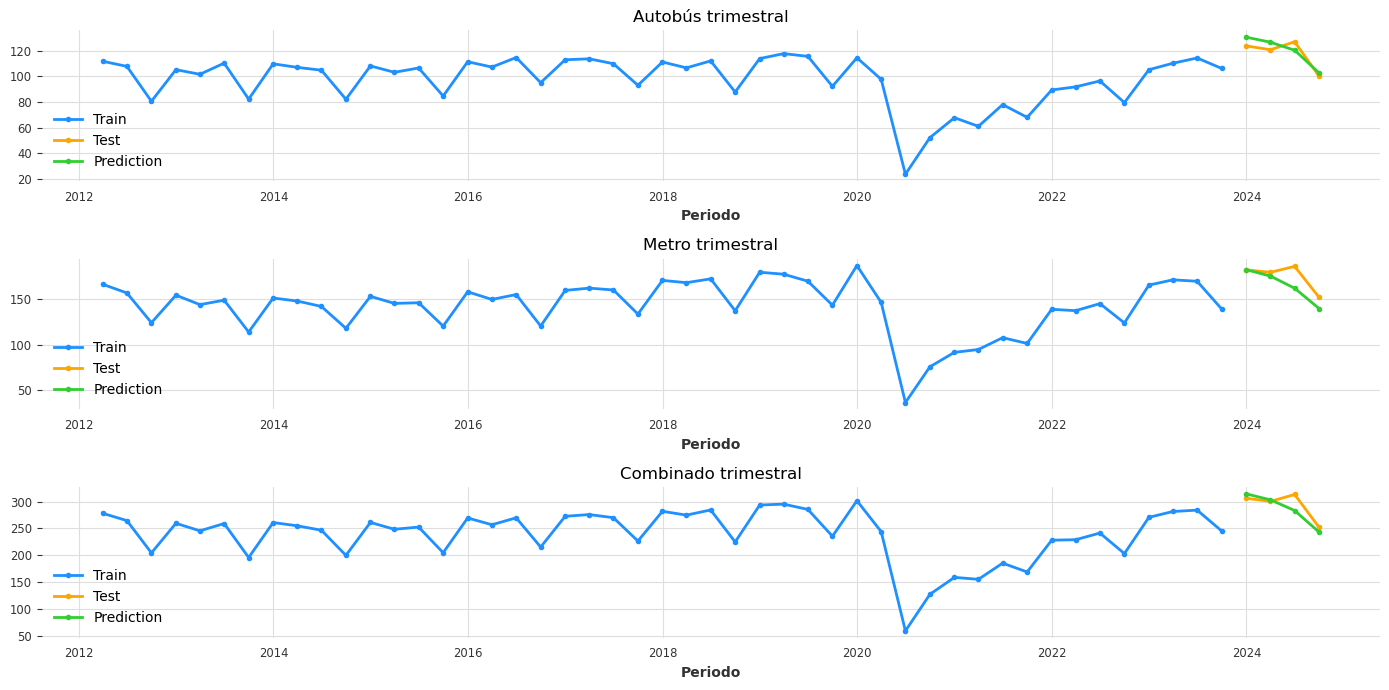

In [105]:
# Separar los datos en conjuntos de entrenamiento y prueba
train_autobus, test_autobus = df_autobus_trim[:-4], df_autobus_trim[-4:]
train_metro, test_metro = df_metro_trim[:-4], df_metro_trim[-4:]
train_combined, test_combined = df_combined_trim[:-4], df_combined_trim[-4:]

# Crear y entrenar el modelo Theta
theta_model = Theta(seasonality_period=4)

# Entrenar el modelo con los datos de autobús
theta_model.fit(train_autobus)
pred_autobus = theta_model.predict(len(test_autobus))

# Entrenar el modelo con los datos de metro
theta_model.fit(train_metro)
pred_metro = theta_model.predict(len(test_metro))

# Entrenar el modelo con los datos combinados
theta_model.fit(train_combined)
pred_combined = theta_model.predict(len(test_combined))

# Graficar los resultados
plt.figure(figsize=(14, 7))

# Graficar los datos de autobús
plt.subplot(3, 1, 1)
train_autobus.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
test_autobus.plot(label='Test', color='orange', marker='o', markersize=3)
pred_autobus.plot(label='Prediction', color='limegreen', marker='o', markersize=3)
plt.title('Autobús trimestral')
plt.legend()

# Graficar los datos de metro
plt.subplot(3, 1, 2)
train_metro.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
test_metro.plot(label='Test', color='orange', marker='o', markersize=3)
pred_metro.plot(label='Prediction', color='limegreen', marker='o', markersize=3)
plt.title('Metro trimestral')
plt.legend()

# Graficar los datos combinados
plt.subplot(3, 1, 3)
train_combined.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
test_combined.plot(label='Test', color='orange', marker='o', markersize=3)
pred_combined.plot(label='Prediction', color='limegreen', marker='o', markersize=3)
plt.title('Combinado trimestral')
plt.legend()

plt.tight_layout()
plt.show()

Para las series trimestrales vemos que la predicción no es mala, pero tampoco perfecta. El modelo logra captar la tendencia pero no se ajusta a los puntos de predicción al completo. Esto me indica que los errores no serán altos a priori, pero tampoco muy bajos.

In [106]:
# Calcular métricas para las predicciones de autobús
mse_autobus, rmse_autobus, mape_autobus = calculate_metrics(test_autobus, pred_autobus)

# Calcular métricas para las predicciones de metro
mse_metro, rmse_metro, mape_metro = calculate_metrics(test_metro, pred_metro)

# Calcular métricas para las predicciones combinadas
mse_combined, rmse_combined, mape_combined = calculate_metrics(test_combined, pred_combined)

print("Métricas para Autobús Trimestral:")
print(f"MSE: {mse_autobus}, RMSE: {rmse_autobus}, MAPE: {mape_autobus}")

print("\nMétricas para Metro Trimestral:")
print(f"MSE: {mse_metro}, RMSE: {rmse_metro}, MAPE: {mape_metro}")

print("\nMétricas para Combinado Trimestral:")
print(f"MSE: {mse_combined}, RMSE: {rmse_combined}, MAPE: {mape_combined}")

Métricas para Autobús Trimestral:
MSE: 32.609415789087436, RMSE: 5.710465461684138, MAPE: 4.53129553312913

Métricas para Metro Trimestral:
MSE: 186.5564606272127, RMSE: 13.658567297751718, MAPE: 5.845973038968093

Métricas para Combinado Trimestral:
MSE: 259.47263135027555, RMSE: 16.10815418818294, MAPE: 4.156256524555424


Observamos buenas métricas, aunque no superiores a los modelos ETS anteriormente predichos para las series trimestrales, los errores son bajos, pero los errores para las series trimestrales de los modelos ETS son aún más bajos.

### **Selección de los parámetros del modelo Theta**

In [107]:
# Búsqueda del mejor parámetro theta, probando 50 valores diferentes Se crea un
# array de 50 valores equidistantes entre -10 y 10
thetas = 2 - np.linspace(-10, 10, 50)

# Inicialización de variables para almacenar el mejor MAPE y el mejor theta
best_metrica = float("inf")
best_theta = 0

# Bucle para probar cada valor de theta
for theta in thetas:
    # Se define el modelo Theta con el valor actual de theta y un período de
    # estacionalidad de 4
    model = Theta(theta, seasonality_period=4)
    # Se ajusta el modelo a los datos de entrenamiento
    model.fit(train_combined)
    # Se generan predicciones para el período de validación
    pred_theta = model.predict(len(test_combined))
    # Se calcula el MAPE de las predicciones
    res = mape(test_combined, pred_theta)
    #res = smape(val, pred_theta) # puedes utilizar smape en lugar de mape
    # Si el MAPE actual es mejor que el mejor MAPE encontrado hasta ahora, se
    # actualizan las variables
    if res < best_metrica:
        best_metrica = res
        best_theta = theta

In [108]:
# Estimación del mejor modelo
best_theta_model = Theta(best_theta,seasonality_period=4)
best_theta_model.fit(train_combined)
pred_best_theta = best_theta_model.predict(len(test_combined))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(test_combined, pred_best_theta), best_theta
    )
)


The MAPE is: 3.78, with theta = 0.16326530612244916.


<Axes: xlabel='Periodo'>

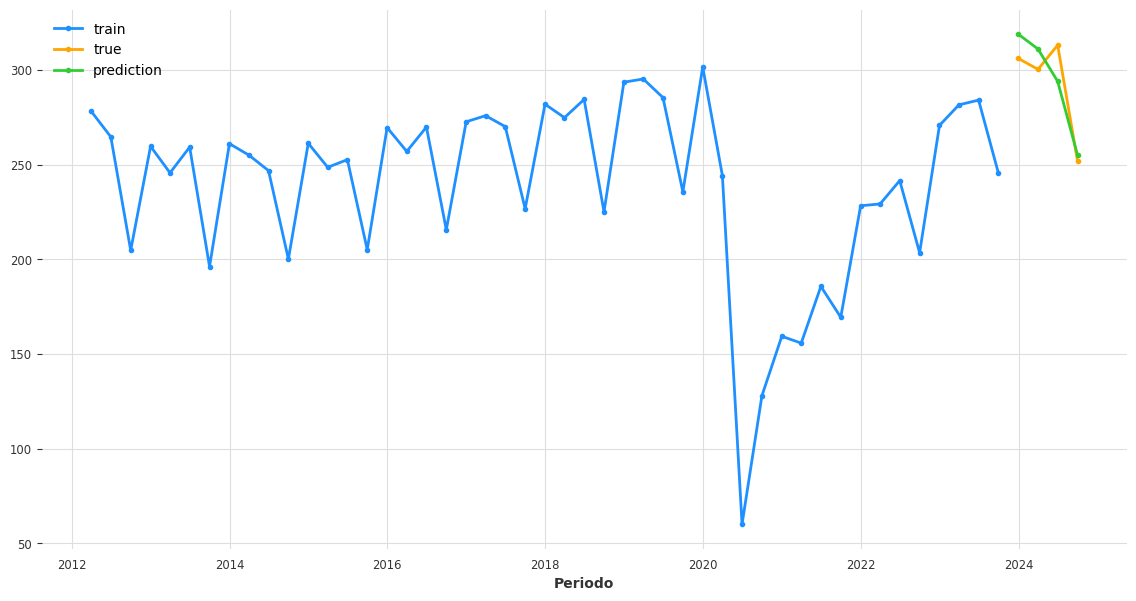

In [109]:
# Grafico
plt.figure(figsize=(14, 7))
train_combined.plot(label="train", color="dodgerblue", marker="o", markersize=3)
test_combined.plot(label="true", color="orange", marker="o", markersize=3)
pred_best_theta.plot(label="prediction", color="limegreen", marker="o", markersize=3)

Esta función de los modelos Theta es interesante, ya que permite encontrar los theta que mejor se ajustan a la predicción y disminuyen los errores. A modo de ejemplo he realizado la selección de dichos parámetros para una sola serie temporal, en este caso la combinada de pasajeros de autobús y metro trimestral. En el caso de que la elección final de la predicción sea este tipo de modelos, realizaré la selección de los mejores parámetros con el objetivo de proporcionar las mejores predicciones posibles.

***

## Modelos 4Theta

El modelo 4Theta es una extensión del modelo Theta tradicional, diseñado para mejorar la flexibilidad y precisión en el pronóstico de series temporales. Mientras que el modelo Theta descompone la serie en componentes lineales y captura patrones mediante un único parámetro de transformación (𝜃), el modelo 4Theta amplía esta metodología al incorporar múltiples parámetros de transformación y combinar diferentes componentes lineales y no lineales. Esto permite una mejor adaptación a series temporales con patrones complejos o no lineales, ofreciendo mayor robustez y precisión en comparación con el modelo Theta estándar.

Veremos si estos modelos superan a los Theta predeterminados. Evaluaremos su predicción tanto mensual como trimestral.

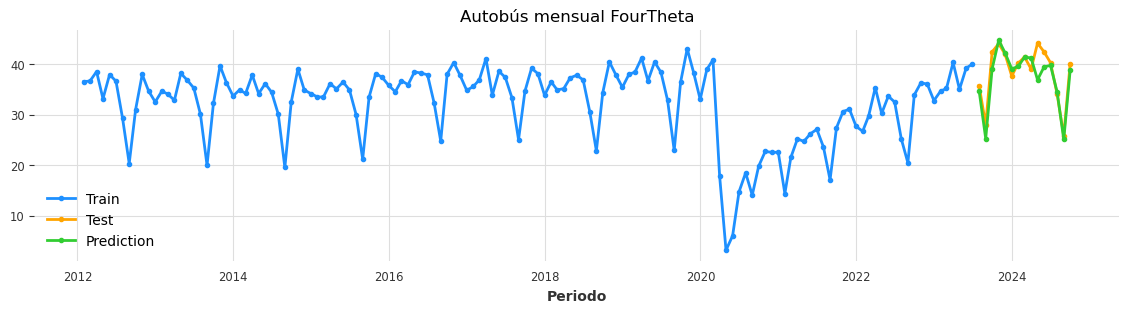

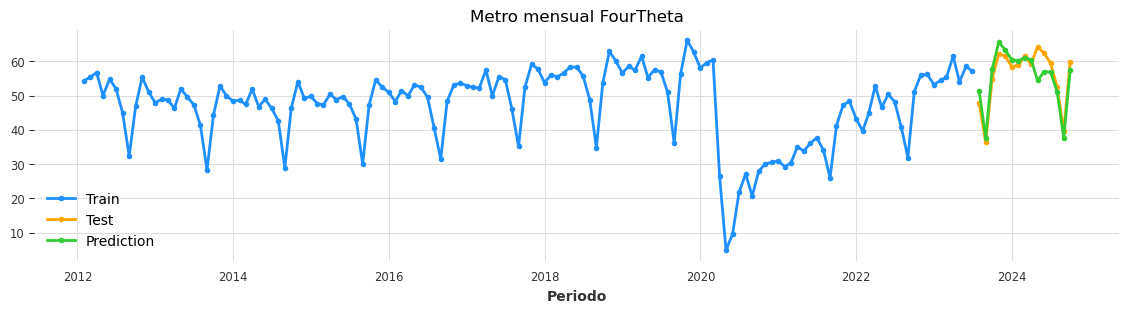

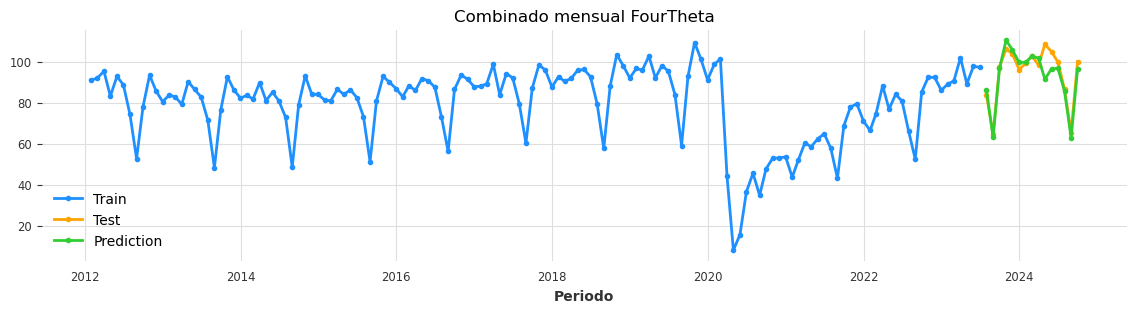

In [110]:
def train_and_plot_fourtheta(train_data, test_data, sp, title):
    # Crear y entrenar el modelo FourTheta
    fourtheta_model = FourTheta(seasonality_period=sp)
    fourtheta_model.fit(train_data)
    pred = fourtheta_model.predict(len(test_data))

    # Graficar los resultados
    plt.figure(figsize=(14, 3))
    train_data.plot(label='Train', color="dodgerblue", marker="o", markersize=3 )
    test_data.plot(label='Test', color="orange", marker="o", markersize=3)
    pred.plot(label='Prediction', color="limegreen", marker="o", markersize=3)
    plt.title(title)
    plt.legend()
    plt.show()

# Separar los datos en conjuntos de entrenamiento y prueba
train_autobus_month, test_autobus_month = df_autobus_month[:-15], df_autobus_month[-15:]
train_metro_month, test_metro_month = df_metro_month[:-15], df_metro_month[-15:]
train_combined_month, test_combined_month = df_combined_month[:-15], df_combined_month[-15:]

# Entrenar y graficar los modelos FourTheta para cada dataframe
train_and_plot_fourtheta(train_autobus_month, test_autobus_month, 12, title='Autobús mensual FourTheta')
train_and_plot_fourtheta(train_metro_month, test_metro_month, 12, title='Metro mensual FourTheta')
train_and_plot_fourtheta(train_combined_month, test_combined_month, 12, title='Combinado mensual FourTheta')


In [111]:
def calculate_metrics(test, pred):
    mse_value = mse(test, pred)
    rmse_value = rmse(test, pred)
    mape_value = mape(test, pred)
    return mse_value, rmse_value, mape_value

# Calcular métricas para las predicciones de autobús mensual FourTheta
fourtheta_model = FourTheta(seasonality_period=12)
fourtheta_model.fit(train_autobus_month)
pred_autobus_fourtheta = fourtheta_model.predict(len(test_autobus_month))
mse_autobus_fourtheta, rmse_autobus_fourtheta, mape_autobus_fourtheta = calculate_metrics(test_autobus_month, pred_autobus_fourtheta)

# Calcular métricas para las predicciones de metro mensual FourTheta
fourtheta_model.fit(train_metro_month)
pred_metro_fourtheta = fourtheta_model.predict(len(test_metro_month))
mse_metro_fourtheta, rmse_metro_fourtheta, mape_metro_fourtheta = calculate_metrics(test_metro_month, pred_metro_fourtheta)

# Calcular métricas para las predicciones combinadas mensual FourTheta
fourtheta_model.fit(train_combined_month)
pred_combined_fourtheta = fourtheta_model.predict(len(test_combined_month))
mse_combined_fourtheta, rmse_combined_fourtheta, mape_combined_fourtheta = calculate_metrics(test_combined_month, pred_combined_fourtheta)

print("Métricas para Autobús Mensual FourTheta:")
print(f"MSE: {mse_autobus_fourtheta}, RMSE: {rmse_autobus_fourtheta}, MAPE: {mape_autobus_fourtheta}")

print("\nMétricas para Metro Mensual FourTheta:")
print(f"MSE: {mse_metro_fourtheta}, RMSE: {rmse_metro_fourtheta}, MAPE: {mape_metro_fourtheta}")

print("\nMétricas para Combinado Mensual FourTheta:")
print(f"MSE: {mse_combined_fourtheta}, RMSE: {rmse_combined_fourtheta}, MAPE: {mape_combined_fourtheta}")

Métricas para Autobús Mensual FourTheta:
MSE: 6.111005316170505, RMSE: 2.472044764192288, MAPE: 4.380409741822658

Métricas para Metro Mensual FourTheta:
MSE: 12.520550345210063, RMSE: 3.5384389701123946, MAPE: 4.8271719731139155

Métricas para Combinado Mensual FourTheta:
MSE: 29.872211723271736, RMSE: 5.465547705699012, MAPE: 3.7076167438011765


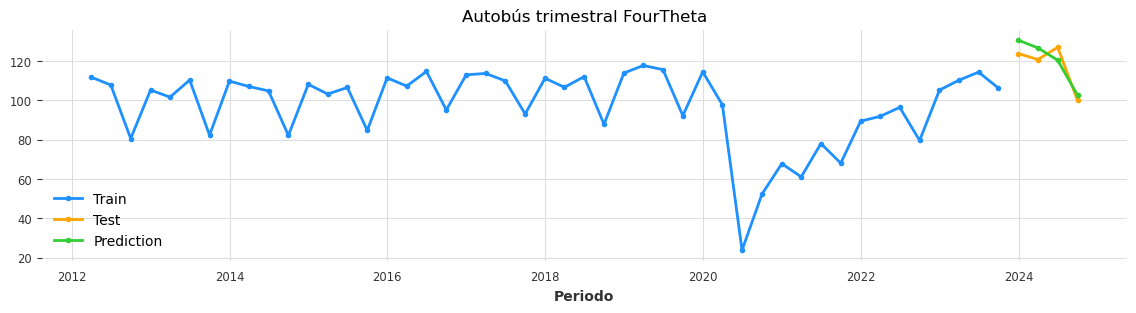

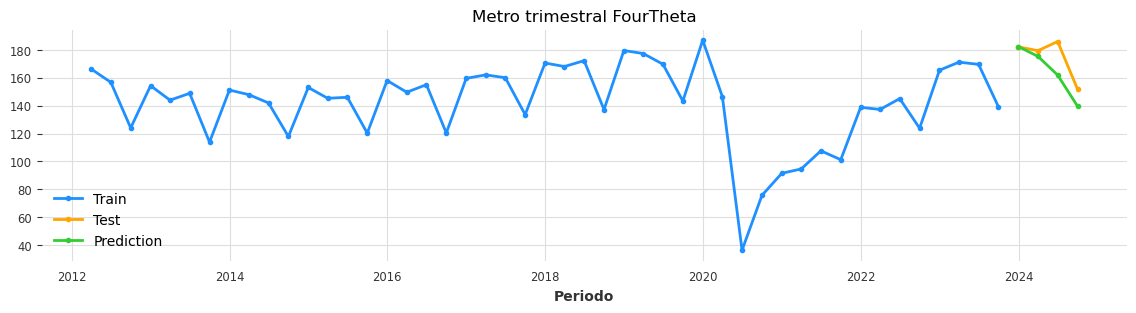

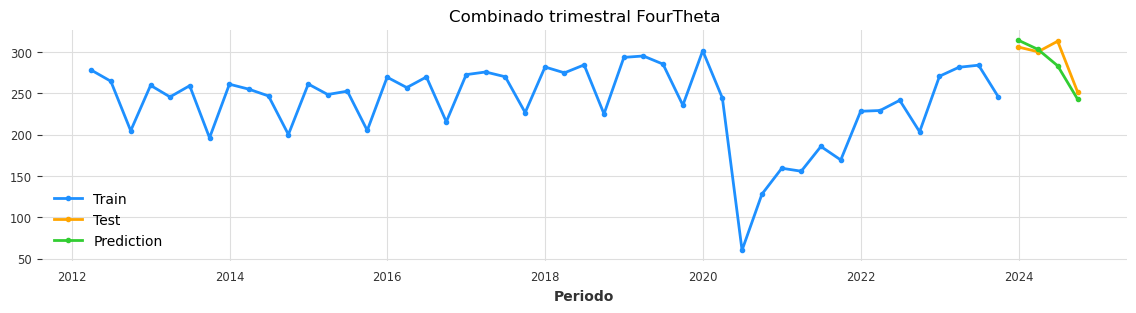

In [112]:
# Separar los datos en conjuntos de entrenamiento y prueba
train_autobus_trim, test_autobus_trim = df_autobus_trim[:-4], df_autobus_trim[-4:]
train_metro_trim, test_metro_trim = df_metro_trim[:-4], df_metro_trim[-4:]
train_combined_trim, test_combined_trim = df_combined_trim[:-4], df_combined_trim[-4:]

# Entrenar y graficar los modelos FourTheta para cada dataframe
train_and_plot_fourtheta(train_autobus_trim, test_autobus_trim, 4, title='Autobús trimestral FourTheta')
train_and_plot_fourtheta(train_metro_trim, test_metro_trim, 4, title='Metro trimestral FourTheta')
train_and_plot_fourtheta(train_combined_trim, test_combined_trim, 4, title='Combinado trimestral FourTheta')

In [113]:
# Calcular métricas para las predicciones de autobús trimestral FourTheta
fourtheta_model = FourTheta(seasonality_period=4)
fourtheta_model.fit(train_autobus_trim)
pred_autobus_trim_fourtheta = fourtheta_model.predict(len(test_autobus_trim))
mse_autobus_trim_fourtheta, rmse_autobus_trim_fourtheta, mape_autobus_trim_fourtheta = calculate_metrics(test_autobus_trim, pred_autobus_trim_fourtheta)

# Calcular métricas para las predicciones de metro trimestral FourTheta
fourtheta_model.fit(train_metro_trim)
pred_metro_trim_fourtheta = fourtheta_model.predict(len(test_metro_trim))
mse_metro_trim_fourtheta, rmse_metro_trim_fourtheta, mape_metro_trim_fourtheta = calculate_metrics(test_metro_trim, pred_metro_trim_fourtheta)

# Calcular métricas para las predicciones combinadas trimestral FourTheta
fourtheta_model.fit(train_combined_trim)
pred_combined_trim_fourtheta = fourtheta_model.predict(len(test_combined_trim))
mse_combined_trim_fourtheta, rmse_combined_trim_fourtheta, mape_combined_trim_fourtheta = calculate_metrics(test_combined_trim, pred_combined_trim_fourtheta)

print("Métricas para Autobús Trimestral FourTheta:")
print(f"MSE: {mse_autobus_trim_fourtheta}, RMSE: {rmse_autobus_trim_fourtheta}, MAPE: {mape_autobus_trim_fourtheta}")

print("\nMétricas para Metro Trimestral FourTheta:")
print(f"MSE: {mse_metro_trim_fourtheta}, RMSE: {rmse_metro_trim_fourtheta}, MAPE: {mape_metro_trim_fourtheta}")

print("\nMétricas para Combinado Trimestral FourTheta:")
print(f"MSE: {mse_combined_trim_fourtheta}, RMSE: {rmse_combined_trim_fourtheta}, MAPE: {mape_combined_trim_fourtheta}")

Métricas para Autobús Trimestral FourTheta:
MSE: 32.71956393503788, RMSE: 5.720101741668402, MAPE: 4.542169807839789

Métricas para Metro Trimestral FourTheta:
MSE: 186.5782532702438, RMSE: 13.659365039058141, MAPE: 5.846278986611552

Métricas para Combinado Trimestral FourTheta:
MSE: 259.3534134925989, RMSE: 16.10445321929928, MAPE: 4.1563921419373315


Los valores de las predicciones son idénticos en ambos modelos. Tanto en el Theta como en el FourTheta, en el caso de que escoja alguno de ellos para generar las predicciones finales, escogeré el Theta ya que el modelo Theta destaca por su simplicidad y eficiencia, lo que lo hace ideal para series con patrones claros y relativamente lineales, como tendencias y estacionalidades bien definidas como la nuestra. Además, es rápido de implementar y requiere menos ajustes, lo que lo convierte en una opción práctica cuando se busca un equilibrio entre precisión y simplicidad.

***
## Validación cruzada

La validación cruzada al utilizar modelos Theta ofrece una evaluación más robusta del rendimiento del modelo, ya que permite probarlo en diferentes segmentos de la serie temporal, asegurando su capacidad para generalizar en datos no vistos. Esto ayuda a reducir el riesgo de sobreajuste, optimizar los parámetros del modelo, como el factor 𝜃, y comparar diferentes configuraciones o variantes de manera confiable. Además, permite adaptar mejor el modelo a las características específicas de la serie, como tendencias cambiantes o patrones estacionales irregulares. En conjunto, la validación cruzada mejora la precisión y confiabilidad de las predicciones obtenidas con modelos Theta.

In [114]:
theta_grid = {
    #'theta': 2- np.linspace(-10, 10, 10),
    'theta':np.linspace(-10, 10, 100),
    #'theta':[-1],
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR],
    'seasonality_period': [12]
}

best_grid_model=FourTheta.gridsearch(parameters=theta_grid,
                                series=train_combined_month,
                                val_series=test_combined_month,
                                #forecast_horizon=8, # 12
                                #start=0.75,
                                last_points_only=False,
                                metric=mape,
                                #reduction=np.mean,
                                verbose=True,
                                n_jobs=-1)

best_grid_model

gridsearch:   0%|          | 0/800 [00:00<?, ?it/s]

(FourTheta(theta=0.30303030303030276, seasonality_period=12, season_mode=SeasonalityMode.MULTIPLICATIVE, model_mode=ModelMode.ADDITIVE, trend_mode=TrendMode.LINEAR, normalization=True),
 {'theta': 0.30303030303030276,
  'model_mode': <ModelMode.ADDITIVE: 'additive'>,
  'season_mode': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>,
  'trend_mode': <TrendMode.LINEAR: 'linear'>,
  'seasonality_period': 12},
 3.381148808252296)

model FourTheta(theta=0.30303030303030276, seasonality_period=12) obtains MAPE: 3.38%


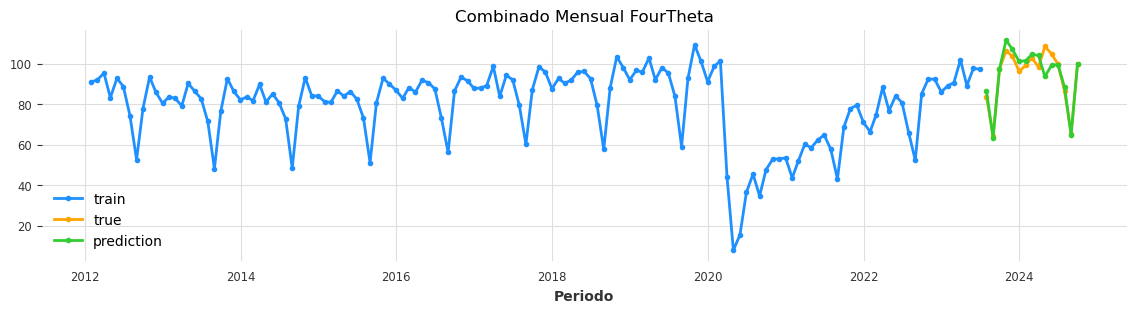

In [117]:
modelo = FourTheta(theta=0.30303030303030276,
                   model_mode=ModelMode.ADDITIVE,
                   season_mode=SeasonalityMode.MULTIPLICATIVE,
                   trend_mode=TrendMode.LINEAR,
                   seasonality_period=12,
                   normalization=True)
modelo.fit(train_combined_month)
pred_modelo = modelo.predict(len(test_combined_month))

plt.figure(figsize=(14, 3))
train_combined_month.plot(label="train", marker='o', markersize=3, color='dodgerblue')
test_combined_month.plot(label="true", marker='o', markersize=3, color='orange')
pred_modelo.plot(label="prediction", marker='o', markersize=3, color='limegreen')
plt.title("Combinado Mensual FourTheta")
plt.legend()

print("model {} obtains MAPE: {:.2f}%".format(modelo, mape(test_combined_month, pred_modelo)))

La validación cruzada proporciona una estimación más confiable de la capacidad predictiva del modelo al medir su desempeño en diferentes segmentos de la serie. Esto ayuda a identificar patrones generales y evita el sobreajuste, asegurando que el modelo generalice bien a datos no vistos. Además, permite comparar de manera objetiva distintos modelos o configuraciones, facilitando la selección del enfoque más adecuado para capturar las características específicas de la serie temporal.

En el caso de que seleccionemos este tipo de modelos de predicción, implementaré validación cruzada para optimizar la búsqueda de combinaciones que mejoren las predicciones.

***
## Conclusión Theta


Las predicciones obtenidas con los modelos Theta para los pasajeros de autobús y metro de Madrid muestran un rendimiento comparable al de los modelos ETS, con métricas sólidas que evidencian la capacidad del modelo para capturar patrones estacionales y tendencias presentes en las series temporales. Esto confirma que los modelos Theta son una alternativa efectiva y confiable para el pronóstico de estas series, especialmente por su simplicidad y adaptabilidad a diferentes estructuras de datos.


Además, una de las grandes ventajas de los modelos Theta es la posibilidad de incorporar validación cruzada en el proceso de modelado, lo que permitiría evaluar de manera más robusta la capacidad de generalización del modelo y afinar sus parámetros para mejorar aún más su precisión. Aunque se ha aplicado en este caso en una sola serie temporal, el mero hecho de que los modelos Theta ofrezcan esta flexibilidad representa un valor añadido significativo, ya que facilita una evaluación más confiable y la posibilidad de ajustar el modelo a las características específicas de las series temporales analizadas.